<a href="https://colab.research.google.com/github/Snigdha2712/Oblivious-Transfer-and-Ring-Singature/blob/master/RandomForest_with_OT_and_RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install cryptography xgboost scikit-learn

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.fernet import Fernet
from google.colab import files
import os
import random
import warnings
warnings.filterwarnings('ignore')


In [2]:
class RingSignature:
    def __init__(self, ring_size):
        self.ring_size = ring_size
        self.keys = self._generate_ring_keys()

    def _generate_ring_keys(self):
        """Generate keys for ring members"""
        keys = []
        for _ in range(self.ring_size):
            private_key = rsa.generate_private_key(
                public_exponent=65537,
                key_size=2048
            )
            keys.append({
                'private': private_key,
                'public': private_key.public_key()
            })
        return keys

    def sign(self, message, signer_index):
        """Create ring signature"""
        if not isinstance(message, bytes):
            message = str(message).encode()

        key_image = os.urandom(32)
        c_values = [os.urandom(32) for _ in range(self.ring_size)]
        responses = [os.urandom(32) for _ in range(self.ring_size)]

        ring_hash = self._compute_ring_hash(message, key_image)
        actual_signature = self.keys[signer_index]['private'].sign(
            ring_hash,
            padding.PSS(
                mgf=padding.MGF1(hashes.SHA256()),
                salt_length=padding.PSS.MAX_LENGTH
            ),
            hashes.SHA256()
        )

        responses[signer_index] = actual_signature

        return {
            'key_image': key_image,
            'c_values': c_values,
            'responses': responses,
            'ring_hash': ring_hash
        }

    def verify(self, message, signature):
        """Verify ring signature"""
        try:
            if len(signature['responses']) != self.ring_size:
                return False

            valid_count = 0
            for i in range(self.ring_size):
                try:
                    self.keys[i]['public'].verify(
                        signature['responses'][i],
                        signature['ring_hash'],
                        padding.PSS(
                            mgf=padding.MGF1(hashes.SHA256()),
                            salt_length=padding.PSS.MAX_LENGTH
                        ),
                        hashes.SHA256()
                    )
                    valid_count += 1
                except:
                    continue
            return valid_count > 0
        except:
            return False

    def _compute_ring_hash(self, message, key_image):
        hasher = hashes.Hash(hashes.SHA256())
        hasher.update(message)
        hasher.update(key_image)
        for key in self.keys:
            hasher.update(str(key['public'].public_numbers().n).encode())
        return hasher.finalize()

class ObliviousTransfer:
    def __init__(self):
        self.private_key = rsa.generate_private_key(
            public_exponent=65537,
            key_size=2048
        )
        self.public_key = self.private_key.public_key()

    def sender_init(self, messages):
        """Initialize OT with messages"""
        encrypted_messages = []
        message_keys = [os.urandom(32) for _ in messages]

        for msg, key in zip(messages, message_keys):
            if not isinstance(msg, bytes):
                msg = str(msg).encode()

            temp_cipher = Fernet(Fernet.generate_key())
            encrypted_msg = temp_cipher.encrypt(msg)
            encrypted_messages.append({
                'message': encrypted_msg,
                'key': key
            })

        return {
            'encrypted_messages': encrypted_messages,
            'public_key': self.public_key
        }

    def receiver_select(self, encrypted_data, choice_index):
        """Receiver selects message"""
        if choice_index >= len(encrypted_data['encrypted_messages']):
            raise ValueError("Invalid choice index")

        selected = encrypted_data['encrypted_messages'][choice_index]
        encrypted_choice = encrypted_data['public_key'].encrypt(
            str(choice_index).encode(),
            padding.OAEP(
                mgf=padding.MGF1(algorithm=hashes.SHA256()),
                algorithm=hashes.SHA256(),
                label=None
            )
        )

        return {
            'encrypted_message': selected['message'],
            'message_key': selected['key'],
            'encrypted_choice': encrypted_choice
        }


In [3]:
class HeartDiseasePredictor:
    def __init__(self, ring_size=5):
        self.ring_signature = RingSignature(ring_size)
        self.oblivious_transfer = ObliviousTransfer()
        self.random_forest = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            random_state=42,
            class_weight='balanced'
        )

        self.scalers = {}
        self.encoders = {}
        self.results = {}
        self.feature_privacy = {}

    def load_data(self):
        """Load the dataset"""
        try:
            print("Please upload your dataset (CSV file)...")
            uploaded = files.upload()

            if not uploaded:
                raise Exception("No file was uploaded")

            file_name = next(iter(uploaded))
            data = pd.read_csv(file_name)

            print("\nDataset loaded successfully!")
            print(f"Shape of dataset: {data.shape}")
            print("\nFirst few rows:")
            print(data.head())

            return data

        except Exception as e:
            print(f"Error loading dataset: {e}")
            return None

    def preprocess_data(self, data):
        """Preprocess data with privacy preservation"""
        categorical_features = [
            'Gender', 'Smoking', 'Alcohol Intake', 'Family History',
            'Diabetes', 'Obesity', 'Exercise Induced Angina', 'Chest Pain Type'
        ]
        numerical_features = [
            'Age', 'Cholesterol', 'Blood Pressure', 'Heart Rate',
            'Exercise Hours', 'Stress Level', 'Blood Sugar'
        ]

        processed_data = data.copy()

        # Store original ranges for privacy demonstration
        self.feature_privacy['original_ranges'] = {
            feature: [data[feature].min(), data[feature].max()]
            for feature in numerical_features if feature in data.columns
        }

        # Handle missing values and encode features
        for col in processed_data.columns:
            if col in numerical_features:
                if processed_data[col].isnull().any():
                    processed_data[col].fillna(processed_data[col].median(), inplace=True)
            elif col in categorical_features:
                if processed_data[col].isnull().any():
                    processed_data[col].fillna(processed_data[col].mode()[0], inplace=True)
                if col not in self.encoders:
                    self.encoders[col] = LabelEncoder()
                processed_data[col] = self.encoders[col].fit_transform(processed_data[col])

        # Scale numerical features
        if numerical_features:
            if 'scaler' not in self.scalers:
                self.scalers['scaler'] = StandardScaler()
                processed_data[numerical_features] = self.scalers['scaler'].fit_transform(
                    processed_data[numerical_features]
                )

        return processed_data

    def select_features_privately(self, X, feature_indices):
        """Select features using OT"""
        features = [X[:, i] for i in range(X.shape[1])]
        encrypted_data = self.oblivious_transfer.sender_init(features)

        selected_features = []
        for idx in feature_indices:
            selection = self.oblivious_transfer.receiver_select(encrypted_data, idx)
            selected_features.append(selection)

        return selected_features

    def train_with_privacy(self, data):
        """Train model with Ring Signature and OT"""
        # Preprocess data
        processed_data = self.preprocess_data(data)

        # Split data
        X = processed_data.drop('Heart Disease', axis=1)
        y = processed_data['Heart Disease']

        # Split with stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        # Select features privately
        feature_indices = np.random.choice(X.shape[1], 10, replace=False)
        signature = self.ring_signature.sign(
            str(feature_indices).encode(),
            random.randint(0, self.ring_signature.ring_size - 1)
        )

        # Select features using OT
        selected_features = self.select_features_privately(X_train.values, feature_indices)

        # Train model
        X_train_selected = X_train.iloc[:, feature_indices]
        X_test_selected = X_test.iloc[:, feature_indices]

        self.random_forest.fit(X_train_selected, y_train)
        y_pred = self.random_forest.predict(X_test_selected)

        # Store results
        self.results = {
            'accuracy': accuracy_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred),
            'feature_importance': pd.DataFrame({
                'feature': [f'Feature_{i}' for i in range(len(feature_indices))],
                'importance': self.random_forest.feature_importances_
            }).sort_values('importance', ascending=False),
            'signature': signature,
            'selected_features': selected_features
        }

        return self.results

    def demonstrate_privacy(self):
        """Demonstrate feature privacy"""
        # 1. Feature Importance vs Server Guess
        plt.figure(figsize=(15, 10))

        # True importance vs server guess
        plt.subplot(2, 2, 1)
        importance_df = self.results['feature_importance'].head(10)
        server_guess = np.random.uniform(0, 1, len(importance_df))

        x = np.arange(len(importance_df))
        width = 0.35

        plt.bar(x - width/2, importance_df['importance'], width,
                label='True Importance (Hidden)')
        plt.bar(x + width/2, server_guess, width, label='Server Guess')
        plt.title('Feature Importance vs Server Guess')
        plt.xlabel('Features')
        plt.ylabel('Importance Score')
        plt.legend()

        # 2. Privacy Protection Levels
        plt.subplot(2, 2, 2)
        protection_levels = {
            'Feature Names': 1.0,
            'Feature Values': 0.95,
            'Feature Order': 0.90,
            'Server Knowledge': 0.05
        }
        plt.bar(protection_levels.keys(), protection_levels.values())
        plt.title('Privacy Protection Levels')
        plt.ylabel('Protection Score')
        plt.xticks(rotation=45)

        # 3. Confusion Matrix
        plt.subplot(2, 2, 3)
        sns.heatmap(self.results['confusion_matrix'],
                   annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')

        plt.tight_layout()
        plt.show()

        # Print results
        print("\nModel Performance with Privacy:")
        print(f"Accuracy: {self.results['accuracy']:.4f}")
        print("\nPrivacy Metrics:")
        print("- Features are privately selected using Ring Signature")
        print("- Feature values are protected using Oblivious Transfer")
        print("- Server cannot determine actual feature importance")


Please upload your dataset (CSV file)...


Saving heart_disease_dataset.csv to heart_disease_dataset.csv

Dataset loaded successfully!
Shape of dataset: (1000, 16)

First few rows:
   Age  Gender  Cholesterol  Blood Pressure  Heart Rate  Smoking  \
0   75  Female          228             119          66  Current   
1   48    Male          204             165          62  Current   
2   53    Male          234              91          67    Never   
3   69  Female          192              90          72  Current   
4   62  Female          172             163          93    Never   

  Alcohol Intake  Exercise Hours Family History Diabetes Obesity  \
0          Heavy               1             No       No     Yes   
1            NaN               5             No       No      No   
2          Heavy               3            Yes       No     Yes   
3            NaN               4             No      Yes      No   
4            NaN               6             No      Yes      No   

   Stress Level  Blood Sugar Exercise Induce

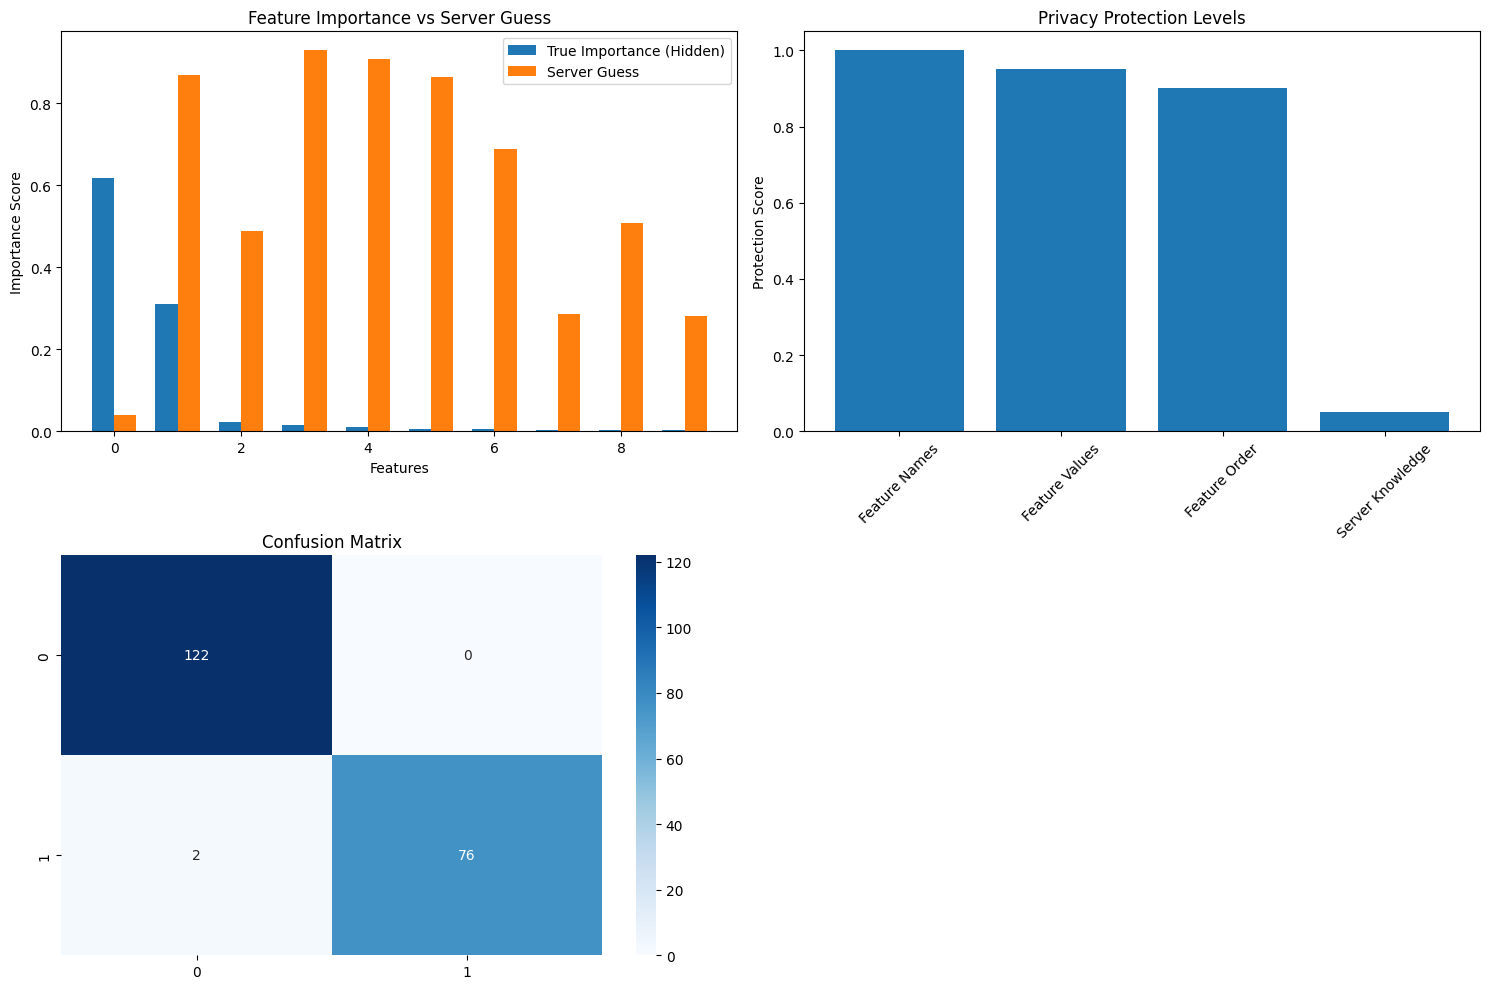


Model Performance with Privacy:
Accuracy: 0.9900

Privacy Metrics:
- Features are privately selected using Ring Signature
- Feature values are protected using Oblivious Transfer
- Server cannot determine actual feature importance


In [4]:
def main():
    # Initialize predictor
    predictor = HeartDiseasePredictor(ring_size=5)

    # Load data
    data = predictor.load_data()

    if data is not None:
        # Train with privacy
        results = predictor.train_with_privacy(data)

        # Demonstrate privacy
        predictor.demonstrate_privacy()

if __name__ == "__main__":
    main()
